In [1]:
import matplotlib.pyplot as plt
import numpy as np
# ^^^ pyforest auto-imports - don't write above this line
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE

In [2]:
"""
OBJECTIVE:
A simple testbed environment with synthetic data to explain the model design and 
implementation more cleanly.

THEORY:
Basics of customer intent analysis:
One of the most basic and widely used targeting methods: look-alike modeling.
The idea of look-alike modeling is to personalize ads or offers based on the similarity of a
given customer to other customers who have exhibited certain desirable or undesirable 
properties in the past. 

We can approach this problem by collecting a number of historical customer profiles that can
include both demographic and behavioral features, attributing those features with the 
observed outcomes, training a classification model based on these samples and then using this
model to score any given customer to determine whether the offer should be issued or not.

This approach provides significant flexibility, in the sense that models can be built for a 
wide variety of business objectives depending on how the outcome label is defined. It also 
works well in a variety of environments, including online advertising and retail promotions.

The solution described above can be extended in a number of ways. One of the apparent 
limitations of basic look-alike modeling is that models for different outcomes and objectives
are built separately, and the useful information about similarities between offerings is 
ignored. 

This issue becomes critical in environments with a large number of offerings, such as 
recommendation systems. Typically, the problem is circumvented by incorporating user 
features, offering features and a larger user-offering interaction matrix into the model so 
that interaction patterns can be generalized across the offerings; it is done in many 
collaborative filtering algorithms, including ones that are based on matrix factorization, 
factorization machines and deep learning methods.

These methods help to predict customer intent more accurately by incorporating a wider range
of data, but this is not particularly useful for optimizing multi-step action strategies.

The problem of strategic optimization can be partly addressed by a more careful design of the
target variable, and this group of techniques represents the second important extension of 
basic look-alike modeling. The target variable is often designed to quantify the probability
of some immediate event like a click, purchase, or subscription cancellation, but it can also
incorporate more strategic considerations. 

For example, it is common to combine look-alike modeling with lifetime value (LTV) models to 
quantify not only the probability of the event, but also its long term economic impact (e.g. 
what will be the total return from a customer retained from churn or what will be a 3-month 
spending uplift after a special offer):

In this case, for a Profile x, we can say that the probability of each Outcome can  be scored
as:

Unconditional Propensity: score(x) = P(response | x)
Expected LVT: score(x) = P(response | x) * LVT(x)
LVT Uplift: score(x) = (P(response | x) - P(response | no offer, x)) * LVT(x)

While these techniques help put the modeling process into a strategic context, they do not 
really provide a framework for optimizing a long-term strategy. So our next step will be to 
develop a more suitable framework, specifically for this problem.

Customer journey as a markov decision process:
The problem of strategic (multi-step) optimization stems from the stateful nature of 
customer relationships and dependencies between actions. For example, one can view retail 
offer targeting as a single-step process where a customer can either be converted or 
completely lost (and train a model that maximizes the probability of conversion):

Offer —> Purchase
  |
  ∨
Lost costumer

However, the real retail environment is more complex and customers can interact with a 
retailer multiple times before a conversion occurs, and the customer makes related purchases.

For instance, in a situation where the actions in the strategy are related, and their order 
is important, the initial action alone may not increase conversions, but it can boost the 
efficiency of the downstream actions. 

It can also be the case that an action is most efficient if issued not in the beginning, but
between two other different actions, and so on.

In complex structures of a customer journey, as customer maturity grows over time, offerings
need to be sequenced properly to account for this.

MARKOV DECISION PROCESSES (MDP):
Use cases can frequently be represented as Markov Decision Processes (MDP), where a customer
can potentially be in several different states and move from one state to another over time 
under the influence of marketing actions. 

In each state, the marketer has to choose an action (or non-action) to execute, and each 
transition between states corresponds to some reward (e.g. number of purchases), so that all
rewards along the customer trajectory sum up to a total return that corresponds to customer 
LTV or campaign ROI.

Although we can use a hand-crafted set of states with clear semantic meaning, we will assume
the state is represented simply by a customer feature vector, so that the total number of 
states can be large or infinite in the case of real-valued features. Note that the state at 
any point of time can include records of all previous actions taken with regard to this 
customer.

In the MDP framework, our goal is to find an optimal policy — π — that maps each state to the 
probabilities of selecting each possible action, so that π(a | s) is the probability of 
taking action — a — given that a customer is currently in state — s. The optimality of the 
policy can be quantified using the expected return under this policy – the expected sum of 
rewards — r — earned at each transition.

A naive solution for this problem is thus to build multiple look-alike models for different 
actions and different designs of the training labels.

In this approach, we first build a set of models (M1.1, M1.2, …) for each action allowed in 
the initial state, using profiles of customers who received this action in the past and with
the target label defined over a long period of time. This label is a direct estimate of the 
expected return. 

We then build a second set of models (M2.1, M2.2, …) using customer profiles with features 
that indicate which action was taken first, and so on. In other words, we optimize actions 
sequentially using the fact that "good" customer trajectories start with "good" initial 
actions for given customer characteristics.

However, this naive approach is computationally inefficient, requires building multiple 
models, and cannot be easily adopted for online learning. We can expect to achieve higher 
efficiency and flexibility using Reinforcement Learning algorithms that solve a generic MDP 
problem.

SOLVING MDP USING FITTED Q ITERATION
In order to apply generic Reinforcement Learning algorithms, we need to introduce a few 
additional concepts that build on the MDP framework and the notions of state, action, reward
and policy that we previously defined.

Assuming that we have some policy — π —, let us introduce the action-value function — Qπ — 
that quantifies the value of taking action — a — in state — s —, as the expected return 
starting from — s —, taking action — a — and following policy — π.

Qπ(s, a) = E(π)[∑_t>ts rt | s, a],

Where: 
E(π) —> Expected-value of policy π;
[∑_t>ts rt | s, a] —> SUM (where moment t is after moment ts) of reward at time t given state
s, action a.

The action-value function can be estimated based on the feedback data (customer trajectories
in our case) collected under policy — π. At the same time, the policy itself can be improved
based on the estimated action-value function. The most basic way to do this is to simply take
the action with the maximum expected value at each state (and, consequently, the 
probabilities of all other actions in this state will be zero):

π(s) = argmax_a xQπ(s, a)

allowing for the process of learning the optimal policy to be iterative, as we can start with
some baseline policy, collect the feedback data under it, learn the action-value function 
from this data, update the policy and repeat the cycle again.

Next, we need an algorithm for the action-value function estimation. Reinforcement Learning 
offers a wide range of such algorithms that are designed for different assumptions about the 
MDP environment. In the most basic case, one can assume a fully known, deterministic and 
computationally tractable environment, so that all states, actions, and rewards are known. 

In this case the action-value function can be straightforwardly estimated using classic 
dynamic programming: we simply compute the total returns for different states as the sums 
of rewards on the paths in the MDP trellis that originate in these states. 

It is not even a machine learning problem, but a purely computational problem. However, 
real environments often impose additional challenges that make this basic approach infeasible
and require the development of more advanced and specialized algorithms.

Generalization: The number of states or transitions can be very large or infinite. In this 
case, the training data (trajectories) we have, might not cover all states and we need to 
generalize our observations using machine learning techniques.

Online learning and exploitation: We might have little or no historical data, and learn 
reward values and states online by trial and error. It leads to the exploration-exploitation
problem: the more time we spend on exploring the environment and learning what works and what
doesn't, the less time we earn high rewards by making optimal actions according to the best 
policy we learned.

Off-policy evaluation and learning: As previously mentioned, policy learning is generally an
incremental process where policy testing and action-value function re-estimation repeats 
iteratively. In many environments we have a limited ability to test arbitrary policies 
because they can lead to inappropriate customer experiences or other issues. This means that
we might need to learn and evaluate policies based on the feedback data generated under other
policies.

These challenges are relevant to this use case: the customer state is defined by the vector 
of real-valued features making the total number of states unlimited, and we generally need to
test and adjust our policy on real customers even if we have historical data to start with.

The first problem of generalization across the states is addressed by a number of different 
Reinforcement Learning algorithms. In fact, we've already seen how this generalization can be
done using look-alike modeling when we discussed our naive algorithm for multi-step 
optimization. 

The more efficient and generic solution for this problem is the Fitted Q Iteration (FQI) 
algorithm.

The idea of the FQI algorithm is to reduce the problem of learning the action-value function
to a supervised learning problem. This is done with the iterative application of some 
supervised learning algorithm; we first train the model to predict the immediate reward based
on state and action features, then train the second model to predict the return for two time
steps ahead, and so on.

More specifically, let us assume that we have a number of trajectories collected under some 
baseline policy, and we cut these trajectories into a set of individual transitions, each of
which is a tuple of the initial state, action, reward and new state:

T = {(s, a, r, s')}

Where:
Input: T -> Set of Transitions
Output: Q(s, a) —> Action-Value Fuction

We initialize Q(s, a) with some initial function, then repeat the following steps until a 
convergence condition:

1) Initialize empty training set D;
2) For each (s_i, a_i, r_i, s'_i) ∈ T:
2.1) Calculate q^_i = r_i + γmax_a'Q(s'_i, a'_i);
2.2) Add sample ((s_i, a_i), q^_i) to D;
3) Learn new Q(s, a) from training set D.

State — s_i — and action — a_i — are assumed to be vectors representing state and action 
features, reward — r — is assumed to be a scalar value, and 0 ≤ γ ≤ 1 is a discount rate that
can be used to control the tradeoff between immediate and long-term rewards.

The algorithm is quite straightforward: we start with a short-sight approximation of the 
action-value function, and then adjust the training label at each iteration to backpropagate
the reward. The FQI algorithm can use any supervised learning algorithm to approximate the
Q function [typical choices are Random Forest and Neural Networks (Neural FQI)].

REFERENCES:
General:
— 

Methods that were originally developed and tested by Adobe and Alibaba:
— G. Theocharous, P. Thomas, and M. Ghavamzadeh, Personalized Ad Recommendation Systems 
for Life-Time Value Optimization with Guarantees, 2015;
— D. Wu, X. Chen, X. Yang, H. Wang, Q. Tan, X. Zhang, J. Xu, and K. Gai, Budget Constrained 
Bidding by Model-free Reinforcement Learning in Display Advertising, 2018;

Other:
— D. Ernst, L. Wehenkel, and P. Geurts, Tree-based batch mode reinforcement learning. 
Journal of Machine Learning Research, 2005;
— M. Riedmiller, Neural Fitted Q Iteration - First Experiences with a Data Efficient Neural 
Reinforcement Learning Method, 2005;
— V. Mnih et al, Human-level Control Through Deep Reinforcement Learning, 2015;
"""

'\nOBJECTIVE:\nA simple testbed environment with synthetic data to explain the model design and \nimplementation more cleanly.\n\nTHEORY:\nBasics of customer intent analysis:\nOne of the most basic and widely used targeting methods: look-alike modeling.\nThe idea of look-alike modeling is to personalize ads or offers based on the similarity of a\ngiven customer to other customers who have exhibited certain desirable or undesirable \nproperties in the past. \n\nWe can approach this problem by collecting a number of historical customer profiles that can\ninclude both demographic and behavioral features, attributing those features with the \nobserved outcomes, training a classification model based on these samples and then using this\nmodel to score any given customer to determine whether the offer should be issued or not.\n\nThis approach provides significant flexibility, in the sense that models can be built for a \nwide variety of business objectives depending on how the outcome label 

In [3]:
"""
STAGING A TESTBED ENVIROMENT
We start building the Next Best Action model by setting up a simple testbed environment. 
First, let us assume a customer can do one of the following Actions at any time step: 
— take no action; 
— visit a website or store without a purchase or 
— make a purchase. 

Let us also assume that a seller can provide a customer with one of three offers at any point
of time or decide not to provide any offer. For the sake of illustration, we assume the 
semantic meaning of these offers are: 
— advertisement; 
— small discount and 
— large discount, 

respectively. 

For the sake of completeness, we also assume that customers have demographic and behavioral 
features. Without loss of generality, we use just one feature that can be either zero or one
depending on the age group.
"""

events = [
    0, # no action
    1, # visit
    2  # purchase
]

offers = [
    1, # advertisement
    2, # small discount
    3  # large discount
]

demographic = [
    0, # young customers
    1  # old customers 
]

In [4]:
"""
Utilities
"""
def multinomial_int(p):
    return np.where(np.random.multinomial(1, p) == 1)[0][0]

def count(ndarray, val):
    return np.count_nonzero(ndarray == val)

def index(ndarray, val, default):
    try:
        return ndarray.tolist().index(val)
    except:
        return default

def find_offer_times(f):
    return np.nonzero(f)[0]

def offer_seq(f):
    return f[np.where(f > 0)]

In [5]:
"""
Next, let's assume that we have some historical data at our disposal to learn the offer 
targeting policy. 

We create a customer profile generator that simulates three historical offer campaigns. 
For each customer, this generator iterates over 100 time steps, and issues three offers at 
randomized points of time. 

We initially use a random targeting policy, so that all offers have the same probability 
regardless of customer features. Customer behavior (i.e. event probabilities) changes over 
time as a function of previously received offers, and also depending upon demographic 
features.
"""
k = 100            # number of time steps
m = len(offers)    # number of offers (campaigns)
n = 1000           # number of customers

In [6]:
def generate_profiles(n, k, m):
    p_offers = [1 / m] * m                                      # offer probabilities 
    
    t_offers = np.linspace(start = 0, stop = k, num = m + 2).tolist()[1 : -1]  
                                                                # offer campaign times
                                                                # Returns num evenly spaced 
                                                                # samples, calculated over 
                                                                # the interval [start, stop]

    t_offer_jit = 5                                             # offer time jitter, std dev 
    
    P = np.zeros((n, k))                                        # matrix of events
    F = np.zeros((n, k))                                        # offer history
    D = np.zeros((n, 1))                                        # demographic features

    for u in range(0, n):
        D[u, 0] = np.random.binomial(1, 0.5)                    # demographic features
    
        # determine m time points to issue offers for customer u
        offer_times_u = np.rint(t_offer_jit * np.random.randn(len(t_offers)) + t_offers)
        
        for t in range(0, k):                                   # simulate a trajectory
            if t in offer_times_u:
                F[u, t] = multinomial_int(p_offers) + 1         # issue an offer at time t 
            
            event = multinomial_int(get_event_pr(D[u], F[u]))   # generate an event at time t
            P[u, t] = event
        
    return P, F, D

In [7]:
def get_event_pr(d, f):
    """
    The most important part of the simulator is a mapper of customer profiles to the vector 
    of event probabilities. We define this mapper in such a way that the probability of a 
    purchase is boosted if and only if the offer #1 (advertisement) is followed by the offer
    #3 (large discount).
    
    Our goal will be to build a model that can recognize this type of dependency. For the 
    sake of simplicity, we ignore demographic features when choosing the event probabilities,
    but the design of the model we develop is fully capable of learning these dependencies as
    well.
    """
    f_ids = offer_seq(f)     # sequence of offer IDs received by the customer
    f_ids = np.concatenate((offer_seq(f), np.zeros(3 - len(f_ids))))
    
    if ((f_ids[0] == 1 and f_ids[1] == 3) or 
       (f_ids[1] == 1 and f_ids[2] == 3) or 
       (f_ids[0] == 1 and f_ids[2] == 3)): 
        p_events = [0.70, 0.08, 0.22]     # higher probability of purchase
    
    else:
        p_events = [0.90, 0.08, 0.02]         # default behavior
        
    if(np.random.binomial(1, 0.1) > 0):       # add some noise
        p_events = [0.70, 0.08, 0.22]
    
    return p_events

In [8]:
def visualize_profiles(P):
    """
    Preparing viz's
    """
    fig, ax = plt.subplots(figsize = (10, 20))
    chart = ax.imshow(P)
    ax.set_aspect(0.05)
    plt.colorbar(chart, fraction = 0.025, pad = 0.04, ax = ax)
    plt.show()

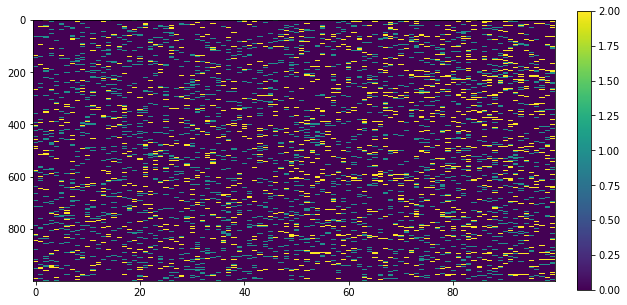

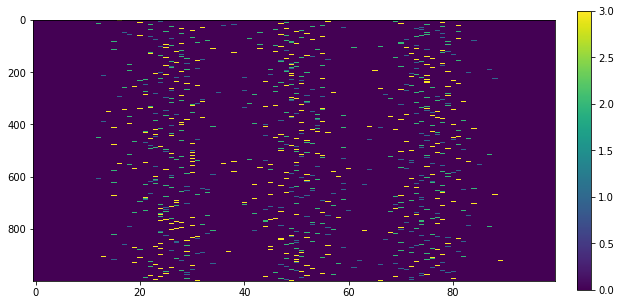

In [9]:
# Next, we generate and visualize the training and test data sets:
P, F, D = generate_profiles(n, k, m)          # training set
Pt, Ft, Dt = generate_profiles(n, k, m)       # test set

visualize_profiles(P)
visualize_profiles(F)

In [10]:
"""
ESTIMATING THE ACTION-VALUE FUNCTION
Our next step is to learn the offer targeting policy using the FQI algorithm we introduced 
earlier. FQI works with individual transitions, so we need to cut the trajectories we 
previously generated.

This way, each customer trajectory produces several transition tuples, and all tuples are 
merged into one training set. We choose to use the number of purchases in each transition as
the reward metric, and represent each state as a vector of the following features: a 
demographic feature, the total number of visits from the beginning of the trajectory and 
time steps at which offers of each type were issued:
"""

def state_features(p, f, d, t_start, t_end):
    """
    p, f, d -> rows of matrices P, F, and D that correspond to a given customer
    t_start, t_end -> time interval 
    """
    p_frame = p[0 : t_end]
    f_frame = f[0 : t_end]
    return np.array([
        d[0],                  # demographic features
        count(p_frame, 1),     # visits
        index(f_frame, 1, k),  # first time offer #1 was issued
        index(f_frame, 2, k),  # first time offer #2 was issued
        index(f_frame, 3, k)   # first time offer #3 was issued
    ])

def frame_reward(p, t_start, t_end):
    return count(p[t_start : t_end], 2)   # number of purchases in the time frame

In [11]:
def prepare_trajectories(P, F, D):
    """
    cutting trajectories into transitions
    """
    T = []
    for u in range(0, n):
        offer_times = find_offer_times(F[u]).tolist()
        ranges = offer_time_ranges(offer_times)
        
        T_u = []
        for r in range(0, len(ranges)):
            (t_start, t_end) = ranges[r]
            state = state_features(P[u], F[u], D[u], 0, t_start)
            reward = frame_reward(P[u], t_start, t_end)
            state_new = state_features(P[u], F[u], D[u], t_start, min(t_end + 1, k))
            
            if(t_end in offer_times): 
                action = F[u, t_end]
            else:
                action = 1 
                
            T_u.append([state, action, reward, state_new])
            
        T.append(T_u) 
        
    return np.array(T)

def offer_time_ranges(times):
    rng = [-1] + times + [k]
    return list(zip(map(lambda x: x + 1, rng), rng[1:]))

In [12]:
# We use it to prepare both training and test sets of transitions:
T = prepare_trajectories(P, F, D)
Tt = prepare_trajectories(Pt, Ft, Dt)

In [13]:
"""
POLICY LEARNING
Once the data is ready, we can apply the FQI algorithm to learn the action-value function. We
use the random forest algorithm from scikit-learn as a subroutine for Q function estimation:
"""
def Q_0(sa):
    return [1]

# find the optimal action under a greedy policy and corresponding state value
def best_action(Q, state, actions):
    v_best = 0
    a_best = 0
    
    for a in actions:
        v = Q([np.append(state, a)])[0]
        
        if(v > v_best):
            v_best = v
            a_best = a
            
    return a_best, v_best

Q = Q_0
iterations = 6

for i in range(iterations):                 # FQI iterations
    X = []
    Y = []
    for sample in T.reshape((n * (m + 1), m + 1)):
        x = np.append(sample[0], sample[1]) # feature vector consists of state-action pairs
    
        a_best, v_best = best_action(Q, sample[3], offers)
        y = sample[2] + v_best              # reward + value
    
        X.append(x)
        Y.append(y)
    
    regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=10)
    regr.fit(X, np.ravel(Y))    
    Q = regr.predict

In [14]:
# Use test set to evaluate the policy
states = Tt[:, :, 0].flatten().tolist()

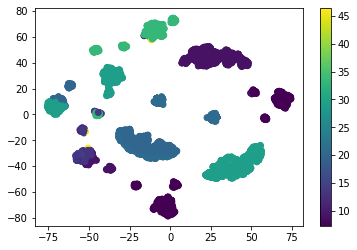

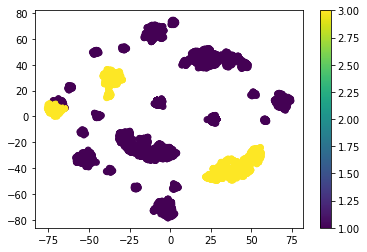

In [15]:
"""
Next, we can use the action-value function to make Next Best Action recommendations for the 
test set. It is insightful to visualize these recommended actions and corresponding 
action-value function estimates:
"""
# use the test set to evaluate the policy
states = Tt[:, :, 0].flatten().tolist()

values = []
best_actions = []
for s in states:
    a_best, v_best = best_action(Q, s, offers)
    values.append(v_best)
    best_actions.append(a_best)

s_tsne = TSNE().fit_transform(states)

# value function for each state
plt.scatter(s_tsne[:, 0], s_tsne[:, 1], c = values)
plt.colorbar()
plt.show()

# recommended next best actions for each state
plt.scatter(s_tsne[:, 0], s_tsne[:, 1], c = best_actions)
plt.colorbar()
plt.show()

In [16]:
"""
POLICY EVALUATION
The top scatter plot shows the value of the best action for each customer state, and the 
bottom plot shows the recommended next best action for each state. The two plots are 
identical except for the color coding. We can see several clusters of customer states 
(segments) with different expected values and recommended actions. As we previously 
described, each state in our model is represented by a vector of five features (demographic,
number of visits and issue times for each of three offers), so it is useful to pull a few 
samples from each of these segments and examine them.

Segment 1: The customers who got offer #3 in the beginning of the trajectory. Our generative 
model boosts the purchase probability only if offer #1 precedes offer #3, so these customers
are lost causes with minimum value.

Segment 2: These customers got offer #2 first. The model rightly recommends to give them 
offer #1 next, but the predicted value for this segment is relatively low because the 
remaining time until the end of the trajectory is limited.

Segment 3: These customers got offer #1 first, and the model recommends to give them offer #3
next. The expected value is relatively high because these customers are on the right track.

Segment 4: These customers already got offer #1 followed by offer #3, and it boosted their 
purchase rates. They have the highest expected values. The system recommends providing them 
offer #1 as a default action, but the recommended action does not make any difference because
the right offer combination has already been unlocked by that time.

FQI provides a way to learn the Q function and derive some policy (e.g. epsilon-greedy) from
it. If we change the policy, we need to evaluate its performance. It can be done using 
historical trajectories.

We need to convert the action-value function into the Next Best Action policy. We have 
already seen that it can be done by taking the action with the highest expected value and 
zeroing the probabilities of taking any other action allowed in a given state. This approach
produces a greedy policy that focuses exclusively on earning rewards according to the 
currently known policy and does not explore alternative (non-optimal) actions in order to 
improve the policy.

Since the learning process is typically interactive or even online, and the data obtained 
under the first policy produced by FQI is then used to learn the next policy, it is common to
use an epsilon-greedy policy that randomly explores non-optimal actions with some small 
probability defined by the hyperparameter — ϵ.

π_ϵ(s, a) = {1 - ϵ if a = argmax_a Qπ(s, a) else ϵ / (m - 1)}

Where — m — is the total number of actions allowed in the state. This gives more bandwidth 
for exploration and policy improvement. In dynamic online environments, the policy can be 
updated many times, and parameter — ϵ — can also be dynamically adjusted depending on the 
volatility of observed feedback. 

The second problem that needs to be addressed is estimating the expected return under the 
optimized policy before this policy is applied in production. It can be needed to ensure that
the new policy meets service quality and performance standards, and may also be required to 
tune parameters of the policy such as the value of — ϵ — in the epsilon-greedy policy.

This policy evaluation can be done using historical trajectories generated using the previous
policy, and rescaling the returns proportionally to the differences between the policies. 

Assuming that we have a trajectory generated using some baseline policy — π_0 — that consists 
of a series of states — s_t — and actions — a_t —, we can estimate the return of a new policy 
— π.

^R(π) = R(π_0)∏_t[π(s_t, a_t) / π_0(s_t, a_t)]

Where R(π_0) is the observed return of the trajectory. 

Averaging this estimate over a set of trajectories, we can evaluate the overall expected 
performance of a policy. This method is called importance sampling estimation.
"""
def make_epsilon_greedy_policy(Q, eps):
    
    def egreedy_policy(state, action):
        a_best, v_best = best_action(Q, state, offers)

        if(a_best == action):
            return 1 - eps
        
        else:
            return eps / (m - 1)
        
    return egreedy_policy

# Probability of action given state
def behavioral_policy(state, action):
    return 1 / m

# Estimates the target policy return based on 
# the profiles (trajectories) P generated under the behavioral policy 
def evaluate_policy_return(T, behavioral_policy, target_policy):
    returns = []
    
    for trajectory in T:                                                   
        importance_weight = 1
        trajectory_reward = 0
        
        for transition in trajectory:            
            state, action, reward  = transition[0: 3]
            action_prob_b = behavioral_policy(state, action)
            action_prob_t = target_policy(state, action)
            
            importance_weight *= (action_prob_t / action_prob_b) 
            trajectory_reward += reward
            
        returns.append(trajectory_reward * importance_weight)
        
    return np.mean(returns)

In [20]:
"""
We use this evaluation procedure to quantify how the expected performance of an 
epsilon-greedy policy depends on the — ϵ — parameter.

Importance sampling and other off-policy evaluation methods provide a way to do safety checks
and modifications before a new policy is deployed in production.
"""
policy_returns = []
eps = np.linspace(0, 2/3, num = 10)
for e in eps:
    policy = make_epsilon_greedy_policy(Q, e)
    policy_returns.append( evaluate_policy_return(T, behavioral_policy, policy) )

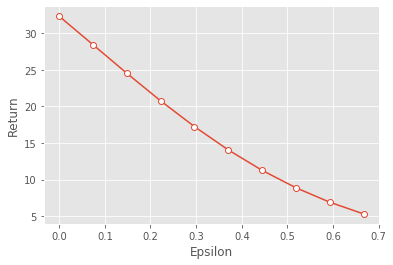

In [21]:
plt.style.use('ggplot')
plt.xlabel('Epsilon')
plt.ylabel('Return')
plt.plot(eps, policy_returns, '-o', mfc='w')
plt.show()

In [ ]:
"""
CONCLUSIONS
Reinforcement learning provides a convenient framework for building Next Best Action models 
that generally need to combine predictive analytics, combinatorial optimization and active 
exploration of a dynamic environment. The ability to combine these elements in different ways
is one of key advantages of the reinforcement learning framework. 

More complex models can be created using Deep Reinforcement Learning methods such as DQN.

The second advantage of the Reinforcement Learning approach is the flexibility of modeling. 
Similar to Monte Carlo simulations, it allows the incorporation of additional requirements, 
such as budgetary constraints, operational costs and business restrictions, by redefining 
reward functions or action sets. This provides more flexibility as compared to the manual 
casting of the optimization problem to some standard form, like linear or integer 
programming.

The same approach can be applied in many other areas of enterprise operations, including 
marketing, pricing, and logistics. 

We used just plain python and scikit-learn to implement our model, but it is highly advisable
to use Reinforcement Learning frameworks like OpenAI Gym for real production implementations
to reliably handle all aspects and edge cases of modeling and optimization.
"""